# Classifiez automatiquement des biens de consommation : 
*Notebook mission 2 - Réalisez une classification supervisée d'images*

**Classification superviée d’images via CNN Transfer Learning**

Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle?

In [144]:
# fonctions personnelles pour le pré traitement des données textuelles
import pre_treatment_text as ptt

import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm

import sklearn

# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

import timeit
import time

from collections import defaultdict
from collections import Counter

import cv2

import os
from os import listdir

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import shutil

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)

print("sklearn version", sklearn.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
sklearn version 1.6.1


## 1 - Préparation du dataset

In [82]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [84]:
# Appliquer la méthode split sur chaque élément de la colonne
y = data['product_category_tree'].apply(lambda x: ptt.clean_category_first_level(x))
data['category'] = y

In [86]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing


## 2 - Création des sous-dossiers par catégorie

On va créer un dossier pour les images d'entraînement, et un dossier pour les images de tests.

In [ ]:
path = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category"

In [110]:
# Définir les dossiers contenant les images
source_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/Images/"  # Dossier où se trouvent les images
train_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category"  # 75% des images
test_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_test"  # 25% des images

# Séparer les données (75% train, 25% test)
df_train, df_test = train_test_split(data, test_size=0.25, stratify=data['category'], random_state=42)

def copy_images(df_subset, destination_folder):
    """ Fonction pour copier les images dans le dossier approprié. """
    for _, row in df_subset.iterrows():
        image_name = row['image']
        category = row['category']

        # Chemin source et destination
        src_path = os.path.join(source_folder, image_name)
        dest_folder = os.path.join(destination_folder, category)
        dest_path = os.path.join(dest_folder, image_name)

        # Créer le dossier s'il n'existe pas
        os.makedirs(dest_folder, exist_ok=True)

        # Vérifier si l'image existe avant de la copier
        if os.path.exists(src_path):
            shutil.copy2(src_path, dest_path)  # Copie sans supprimer l'original
            print(f"✅ {image_name} copié dans {dest_folder}")
        else:
            print(f"⚠️ Image non trouvée : {image_name}")

# Copier les images dans les dossiers appropriés
print("📂 Copie des images d'entraînement...")
copy_images(df_train, train_folder)

print("📂 Copie des images de test...")
copy_images(df_test, test_folder)

print("✅ Opération terminée (75% entraînement, 25% test) !")

📂 Copie des images d'entraînement...
✅ 96bc1fbb83ad5a2c0441d132fe8bcf97.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Baby Care
✅ 22ac36ba254a68d7dd6173f099771147.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Baby Care
✅ 7915f1c0703450d4b1446c06066d9a59.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Furnishing
✅ 90906358dac904c4f05c12c798ac5221.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Furnishing
✅ 95cb9561009bd6707c67f05e6a00c16e.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Decor  Festive Needs
✅ d1e18b4a3aafb0040da2111c8b8ce2e5.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Decor  Festive Needs
✅ 87f256eeace1a0c2b1f934f061646da5.jpg copié dans C:/Users/ad

## 3 - Création du modèle de classification

- Charge le modèle pré-entraîné VGG16
  
  + include_top=False : Supprime les couches de classification de VGG16.
  + weights="imagenet" : Charge les poids pré-entraînés sur ImageNet.
  + input_shape=(224, 224, 3) : Définit l’entrée du réseau pour des images couleur de 224×224 pixels.

- Gèle les couches du modèle pré-entraîné

  + Empêche la modification des poids de VGG16 pendant l'entraînement.
  + Seules les couches ajoutées seront entraînées.

- Ajoute des couches supplémentaires

  + GlobalAveragePooling2D : Réduit la dimension de sortie sans trop de paramètres.
  + Dense(256, activation='relu') : Ajoute une couche entièrement connectée.
  + Dropout(0.5) : Réduit le risque d'overfitting en désactivant 50% des neurones.
  + Dense(4, activation='softmax') : La dernière couche de classification avec 7 classes.

- Crée et compile le modèle

  + Définit le modèle final avec comme entrée VGG16 et comme sortie la nouvelle couche de classification.
  + Compile le modèle

In [112]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    # loss="categorical_crossentropy" → Adapté pour un problème de classification multi-classes.
    # optimizer='rmsprop' → Optimiseur recommandé pour le fine-tuning.
    # metrics=["accuracy"] → Suit la précision du modèle.
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

## 4 - Approche nouvelle par Dataset avec data augmentation intégrée au modèle

L’approche nouvelle par dataset avec data augmentation intégrée au modèle désigne une méthode dans laquelle l'augmentation des données (data augmentation) est effectuée directement dans le pipeline du modèle, plutôt que d’être réalisée en amont (par prétraitement des images).

- Data Augmentation = technique permettant d’augmenter artificiellement la taille et la diversité d’un dataset en appliquant des transformations (rotation, zoom, bruit, etc.) sur les images d’entraînement. Cela améliore la généralisation du modèle et réduit le surapprentissage (overfitting).

- Intégrée au Modèle = l’augmentation des données n’est pas faite en prétraitement (offline) mais au moment de l'entraînement, via des couches spécifiques ou un pipeline de traitement dynamique.

Avantages :
- Gain de temps : Pas besoin de stocker un grand volume de données augmentées.
- Flexibilité : Les transformations sont appliquées différemment à chaque époque d'entraînement.
- Optimisation mémoire : Les images sont augmentées à la volée, ce qui évite de stocker une grande base de données augmentée.

**fonction pour charger un dataset d'images** à partir d'un répertoire en utilisant image_dataset_from_directory de TensorFlow/Keras.

- path : Spécifie le chemin du dataset.
- labels='inferred' : TensorFlow détecte automatiquement les labels en fonction des noms de dossiers.
- label_mode='categorical' : Les labels sont encodés sous forme one-hot (ex. [0, 1, 0, 0] pour une classe parmi 4).
- class_names=None : Les noms des classes sont détectés automatiquement.
- batch_size=batch_size : Définit la taille des mini-batches.
- image_size=(224, 224) : Redimensionne les images en 224×224 pixels (exigé par VGG16).
- shuffle=True : Mélange les images pour améliorer la généralisation.
- seed=42 : Assure une répartition reproductible des données.
- validation_split=validation_split : Si non nul, sépare une partie du dataset pour la validation.
- subset=data_type : Spécifie si on charge le dataset d'entraînement ("training") ou de validation ("validation").

In [114]:
batch_size = 32
path = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category"
path_test = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_test"

In [133]:
def dataset_fct(path, validation_split=0, data_type=None) :
    """
        path : Chemin du dossier contenant les images organisées en sous-dossiers par classe.
        validation_split : Pourcentage du dataset à utiliser pour la validation (ex. 0.2 pour 20%).
        data_type : Détermine si on charge les données d'entraînement ("training") ou de validation ("validation").
    """

    #  Création du dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

**Créons les dataset d'entrainement, de validation et de test**

In [118]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 787 files belonging to 7 classes.
Using 591 files for training.
Found 787 files belonging to 7 classes.
Using 196 files for validation.
Found 263 files belonging to 7 classes.


**Créons une fonction de normalisation de l'image**

- Conversion et redimensionnement de l’image
- Normalisation des pixels

In [131]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)   # Convertit l’image en type float32 pour éviter des problèmes de format
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])   # Redimensionne l’image aux dimensions IMG_SIZE x IMG_SIZE (ex : 224x224 pour VGG16).
    image = (image / 255.0)   # prétraitement standard pour les réseaux de neurones
    return image, label

**Créons la fonction de création du modèle de deep learning ave VGG16**

- Augmentation de données
- Récupération du modèle pré-entraîné VGG16
- Définition du modèle final créé avec un Sequential
- Compilation du modèle

In [129]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),   # Effectue un retournement horizontal aléatoire de l'image
        RandomRotation(0.1),    # Effectue une rotation aléatoire des images dans une plage de -10% à +10% de l'angle
        RandomZoom(0.1),   # Applique un zoom aléatoire avec une amplitude de 10%
      ])
    
    # Récupération modèle pré-entraîné
    #include_top=False : retirer la dernière couche entièrement connectée 
    #weights="imagenet" : Utilise les poids pré-entraînés sur ImageNet.
    #input_shape=(224, 224, 3) : Spécifie la taille des images d'entrée (ici 224x224 pixels, avec 3 canaux de couleur).
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,  # Les images passent d'abord par les étapes d'augmentation de données
                Rescaling(1./127.5, offset=-1),   # Les pixels de l'image sont mis à l'échelle
                model_base,    # La partie pré-entraînée du modèle VGG16
                GlobalAveragePooling2D(),  # Cette couche réduit la sortie de VGG16 en un vecteur de caractéristiques de taille fixe
                Dense(256, activation='relu'),   # Une couche dense avec 256 neurones et une fonction d'activation ReLU
                Dropout(0.5),   # Une couche de dropout pour réduire le surapprentissage
                Dense(7, activation='softmax')    # La couche de sortie avec 7 neurones + a fonction d'activation softmax produit des probabilités pour chaque classe
                ])

    # compilation du modèle 
    # categorical_crossentropy : Une fonction de perte utilisée pour les problèmes de classification multi-classes.
    # optimizer='adam' : L'optimiseur Adam est utilisé, car il est robuste et efficace pour la plupart des problèmes.
    # metrics=["accuracy"] : La métrique utilisée pour évaluer les performances du modèle est la précision.    
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

- Création du modèle sur le GPU
- Création d'un Callback pour sauvegarder le meilleur modèle
- Création d'un Callback pour arrêter l'entraînement si nécessaire
- Regroupement des Callbacks

In [162]:
# Détection automatique du GPU ou utilisation du CPU
device = "/gpu:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"

# Création du modèle
with tf.device(device): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.keras" 

checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [153]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Normal car je n'ai pas de GPU installé, j'ai utilisé la CPU.

**Entraînons un modèle**

- Détection du périphérique
- Entraînement du modèle
- Enregistrer les performances

In [165]:
# Vérifier si un GPU est disponible
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

with tf.device(device): 
    history4 = model4.fit(dataset_train,
                          validation_data=dataset_val,
                          batch_size=batch_size, epochs=50, # Le nombre d'époques d'entraînement : 50 fois.
                          callbacks=callbacks_list, # liste de rappels (callbacks) utilisés pendant l'entraînement pour exécuter certaines actions
                          verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2032 - loss: 2.0289
Epoch 1: val_loss improved from inf to 1.44726, saving model to ./model4_best_weights.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.2057 - loss: 2.0226 - val_accuracy: 0.6480 - val_loss: 1.4473
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4606 - loss: 1.5538
Epoch 2: val_loss improved from 1.44726 to 1.14676, saving model to ./model4_best_weights.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.4624 - loss: 1.5500 - val_accuracy: 0.6786 - val_loss: 1.1468
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5797 - loss: 1.2262
Epoch 3: val_loss improved from 1.14676 to 0.94176, saving model to ./model4_best_weights.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 161s 9s/step - accuracy: 0.5818 - loss: 1.2241 - val_accuracy: 0.7602 - val_loss: 0.9418
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6223 - loss: 1.1156
Epoch 4: val_loss improved from 0.94

**Evaluons la performance du modèle**

- Charger les poids du modèle
- Evaluation du modèle sur le jeu de validation
- Évaluation du modèle sur le jeu de test

Interprétation de l'accuracy: l'accuracy est toujours une valeur entre 0 et 1

- 0 : Le modèle a fait des prédictions incorrectes pour toutes les données.
- 1 : Le modèle a fait des prédictions correctes pour toutes les données.

In [172]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

# loss, accuracy : Ce sont les deux valeurs retournées par la méthode evaluate(). 
# La première est la perte (une mesure de l'erreur du modèle) et
# la seconde est la précision (le pourcentage de prédictions correctes).
loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7704
Test Accuracy       :  0.7871


**Affichons les courbes**

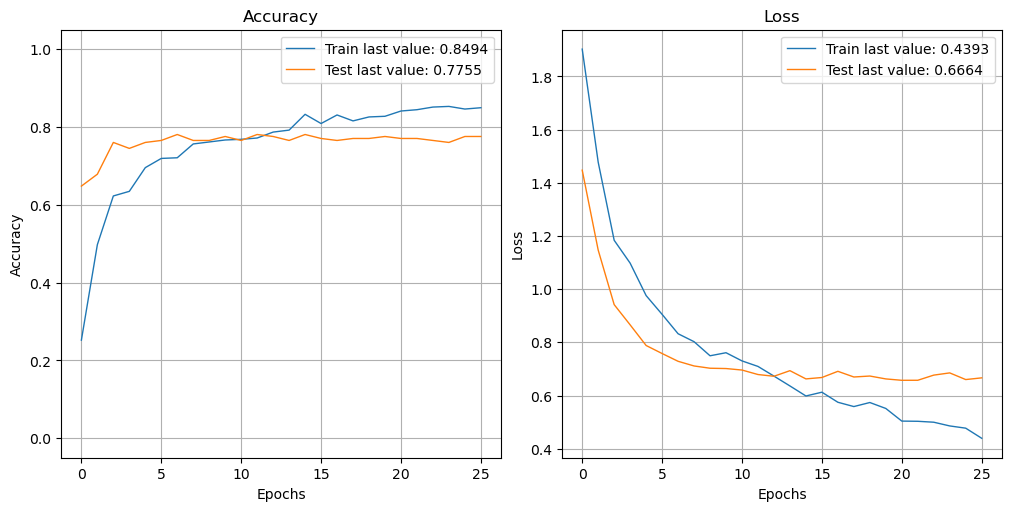

In [183]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

**Affichons la courbe ROC**

Liste des classes dans l'ordre du modèle lors de l'entraînement :

In [223]:
class_names = dataset_test.class_names
print("Classes:", class_names)

Classes: ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor  Festive Needs', 'Home Furnishing', 'Kitchen  Dining', 'Watches']


Faisons les prédictions :

In [197]:
y_test = df_test['category']

y_test_predict = model4.predict(dataset_test, verbose=False)
y_test_predict

array([[1.4377743e-02, 1.5071946e-01, 2.3690052e-01, ..., 1.4969599e-02,
        9.7090326e-02, 1.3156824e-02],
       [5.0605508e-05, 9.9932969e-01, 1.9254777e-04, ..., 6.6402522e-06,
        1.9436056e-04, 1.5549045e-05],
       [7.0425019e-02, 2.1236537e-02, 6.4575938e-03, ..., 4.3475175e-01,
        2.9283077e-02, 6.2310058e-03],
       ...,
       [1.4136606e-01, 3.9339715e-01, 1.5161546e-02, ..., 3.6265579e-01,
        1.8746292e-02, 5.9138075e-03],
       [4.9096649e-03, 3.9066285e-01, 5.0486207e-01, ..., 2.2533846e-03,
        1.7484710e-02, 1.0969926e-02],
       [4.7105205e-01, 5.0220933e-02, 4.3904055e-02, ..., 1.0545414e-02,
        2.8878525e-01, 2.4051918e-02]], dtype=float32)

Préparons le fichier des vraies catégories pour qu'il puisse être comparé aux prédictions :

In [228]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# liste des catégories dans l'ordre des sous-dossiers d'images utilisés lors de l'entraînement
labels = ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor  Festive Needs', 'Home Furnishing', 'Kitchen  Dining', 'Watches']

# Créer un dictionnaire pour mapper les catégories à des indices
label_to_index = {label: index for index, label in enumerate(labels)}

# Convertir y_test en indices numériques
y_test_indices = [label_to_index[label] for label in y_test]

# Convertir les indices en one-hot encoding
y_test_one_hot = to_categorical(y_test_indices, num_classes=len(labels))

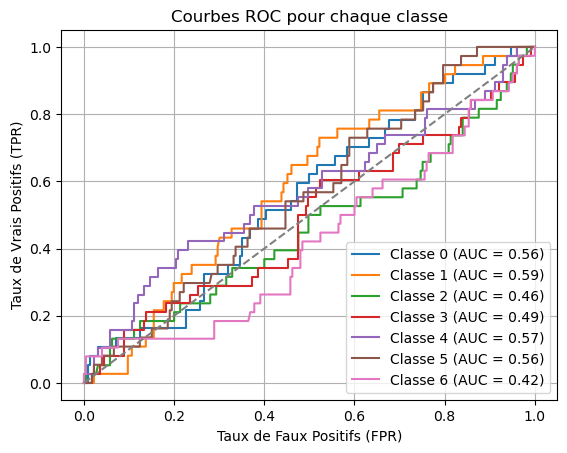

In [230]:
# Calculer la courbe ROC pour chaque classe
for i in range(7):  # 7 classes dans votre cas
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_test_predict[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {roc_auc:.2f})')

# Affichage de la courbe ROC pour toutes les classes
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale aléatoire
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC pour chaque classe')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [211]:
y_test

973    Home Decor  Festive Needs
594    Home Decor  Festive Needs
601              Kitchen  Dining
604                    Computers
208    Home Decor  Festive Needs
                 ...            
166              Kitchen  Dining
42                     Baby Care
623                    Baby Care
698              Home Furnishing
187              Kitchen  Dining
Name: category, Length: 263, dtype: object